# Query Vizier-SED for one star and classify it

**@juliaroquette 23 December 2025** Example of usage of the package for retrieving VizieR-SED data for one source and classifying it into the standard classification scheme. 

In [1]:
import numpy as np
from sed.classifyYSO import YSOClassifier
import os

Set coordinates for query. Note that name here is for labelling only as no function to query by name has been implemented. 

In [2]:
ra = 83.86937
dec = -4.79072
radius = 10.0  # arcseconds
ID = "V1547Ori"


## query it with `sed.vizierSED.Source`

In [3]:
from sed.vizierSED import Source

Setting `raw_cache_dir=None` will not save raw files to disk.

In [4]:
star = Source(
    ra,
    dec,
    radius,
    ID=ID,
    raw_cache_dir=None
)

The query output is stored in the `star.sed`, and includes more information than simply the fluxes. For example, some catalogues provide exposure time, and every photometric point will have its own coordinate,

In [5]:
print(f"Source {star.internal_id} had {len(star.sed)} measurements within {radius} arcsec.")

Source V1547Ori had 330 measurements within 10.0 arcsec.


In [6]:
star.sed.head()

,_RAJ2000,_DEJ2000,_tabname,_ID,_time,_etime,sed_freq,sed_flux,sed_eflux,sed_filter,dist_to_center,sed_lambda
209,83.868226,-4.788446,II/379/smssdr4,"-c=083.868226 -04.788446,eq=ICRS&-c.rs=0.004",NaN,0.0,857000.0,0.000410,0.000024,SkyMapper/SkyMapper:u,9.157597,0.349816
208,83.868226,-4.788446,II/379/smssdr4,"-c=083.868226 -04.788446,eq=ICRS&-c.rs=0.004",NaN,0.0,857000.0,0.000772,0.000099,SkyMapper/SkyMapper:u,9.157597,0.349816
207,83.868226,-4.788446,II/379/smssdr4,"-c=083.868226 -04.788446,eq=ICRS&-c.rs=0.004",NaN,0.0,774500.0,0.001510,0.000060,SkyMapper/SkyMapper:v,9.157597,0.387079
206,83.868226,-4.788446,II/379/smssdr4,"-c=083.868226 -04.788446,eq=ICRS&-c.rs=0.004",NaN,0.0,774500.0,0.002090,0.000330,SkyMapper/SkyMapper:v,9.157597,0.387079
289,83.868231,-4.788417,IV/38/tic,"-c=083.86823081638 -04.78841655136,eq=J2000&-c...",NaN,0.0,674900.0,0.006150,0.000130,Johnson:B,9.244760,0.444203


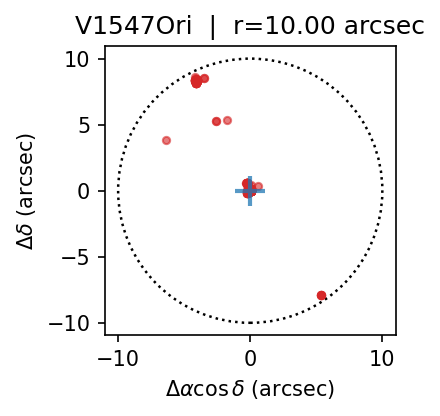

<Axes: title={'center': 'V1547Ori  |  r=10.00 arcsec'}, xlabel='$\\Delta \\alpha \\cos\\delta$ (arcsec)', ylabel='$\\Delta \\delta$ (arcsec)'>

In [7]:
star.plot_measurement_positions()

The plot below shows everything found on VizieR-SED for this star.

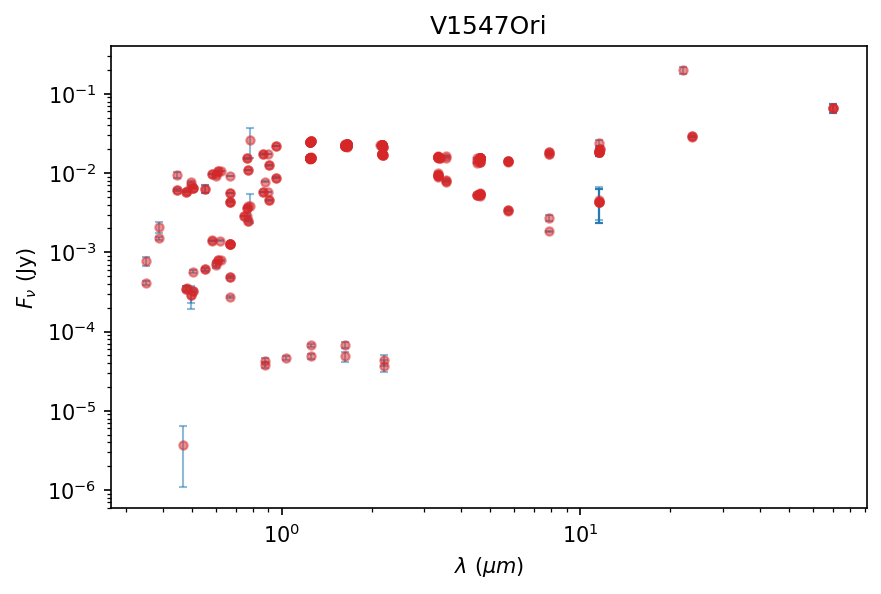

In [8]:
ax = star.plot_sed(show=True, color="tab:red", ecolor="tab:blue", alpha=0.5)


We can keep this version of the query for later plotting.

In [9]:
lam, flux, eflux = star.get_plot_arrays()

## Post-processing it 

There is a bunch of processing steps that can be applied.

### By dropping certain catalogues, filters, surveys, wavelength ranges, etc.

1. Blacklist
The file `input/black_list.yaml` includes a black list of surveys that should be removed from most analysis. This file can be modified and extended. 
These are more or less organized into three categories:
- 'outdated_surveys': include obsolete surveys. For example Gaia DR1 `I/337/gaia`
- 'weird_surveys': These are surveys that Gabor or Julia identified as weird photometry. For example, SDSS 16, `V/154/sdss16`, has a bunch of aperture photometry for different apertures. 
- 'custom_skip': can include anything else. 


This blacklist is managed by `sed.config_blacklist`, where `load_black_list` will read the `.yaml` file and format it into an appropriate format. 

In [10]:
from sed.config_blacklist import load_black_list, apply_blacklist

In [11]:
blacklist_config = load_black_list(os.path.join("..", "input", "black_list.yaml"))

In [12]:
blacklist_config.keys()

dict_keys(['outdated_surveys', 'weird_surveys', 'custom_skip'])

The black list can be enforced with `apply_blacklist`. If desired, a restricted set of categories in the blacklist will be applied by setting, for example, `keys=['outdated_surveys', 'weird_surveys']`

In [13]:
apply_blacklist(star, blacklist_config, keys=['outdated_surveys', 'weird_surveys'])

For example, below we show the SED before and after applying the blacklist.

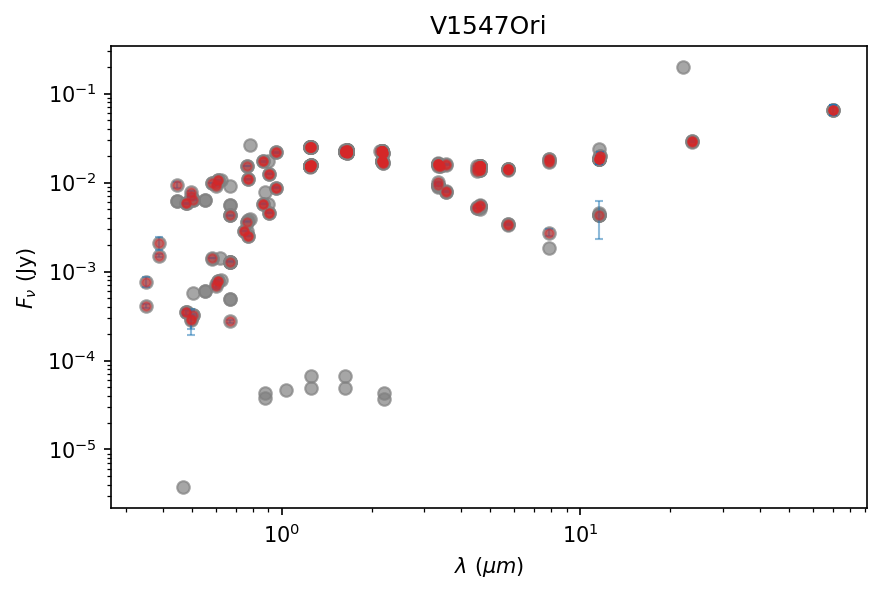

In [14]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam, flux, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

In [15]:
lam_, flux_, eflux_ = star.get_plot_arrays()

2. Drop a wavelength range: the method `Source.drop_wavelength_range(min_wavelength, max_wavelength)` can be used to remove all measurements within a specified wavelength range (in microns). For example, to drop all measurements between 0.1 and 0.5 microns:

In [16]:
star.drop_wavelength_range(0.1, 0.5)  # microns

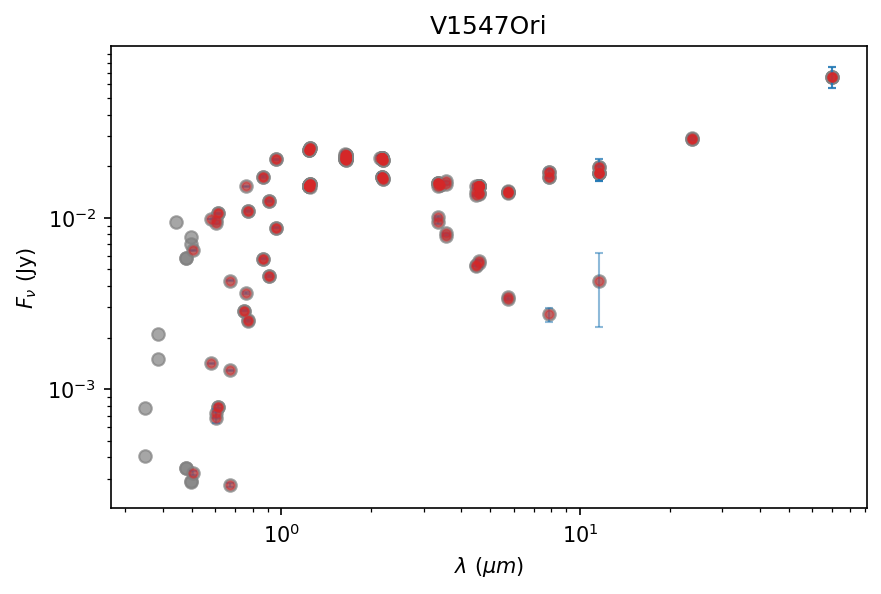

In [17]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

3. Reset radius: We can see from this example that there are multiple sources mixed in the SED. This is because we used a 10" searching radius, which is large enough to cause confusion of sources. `Source.confine(new_radius)` can be used to reduce the searching radius on fly. 

In [18]:
star.confine(2.)

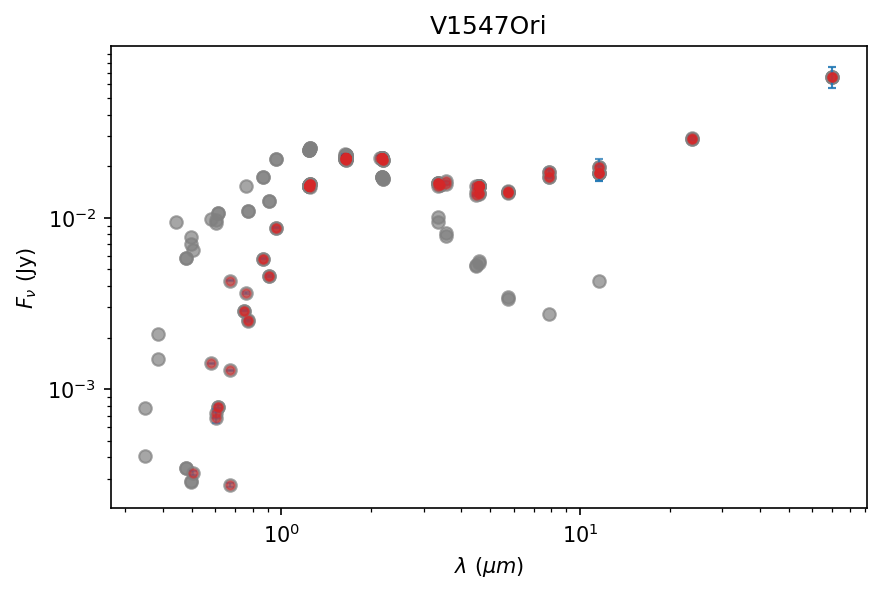

In [19]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

In [20]:
lam_, flux_, eflux_ = star.get_plot_arrays()

4. Drop a full catalogue. For example sake, here I am droping Gaia DR3 data:

In [21]:
star.dropCatalog('I/355/gaiadr3')

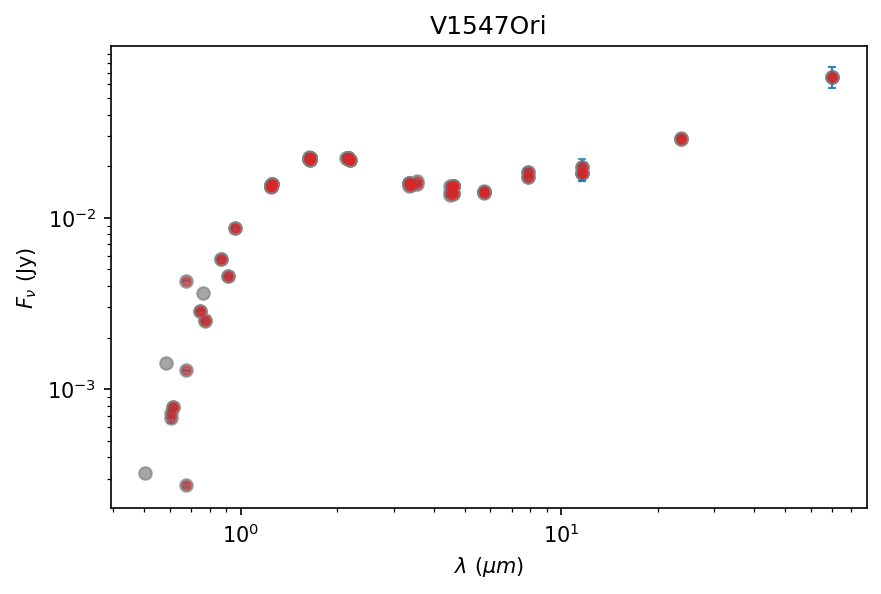

In [22]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

In [23]:
lam_, flux_, eflux_ = star.get_plot_arrays()

5. Drop a named filter. For example, let's say we want to additionally to drop Gaia DR3 data from the official release, we also want to make sure all re-reported Gaia G measurements are dropped:

In [24]:
star.dropFilter("Gaia:G")

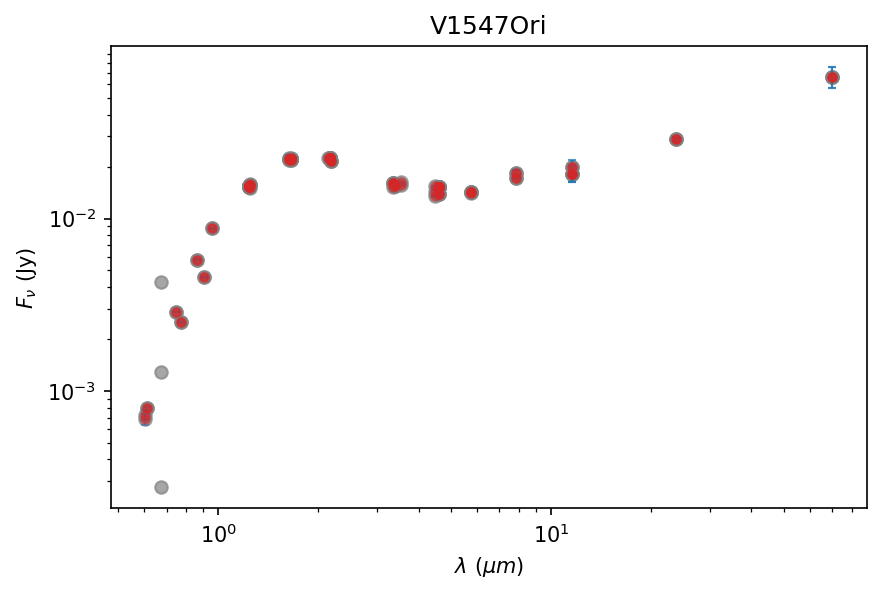

In [25]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

6. Keep only a certain wavelength range 

In [26]:
star.keep_wavelength_range(1., 24.)

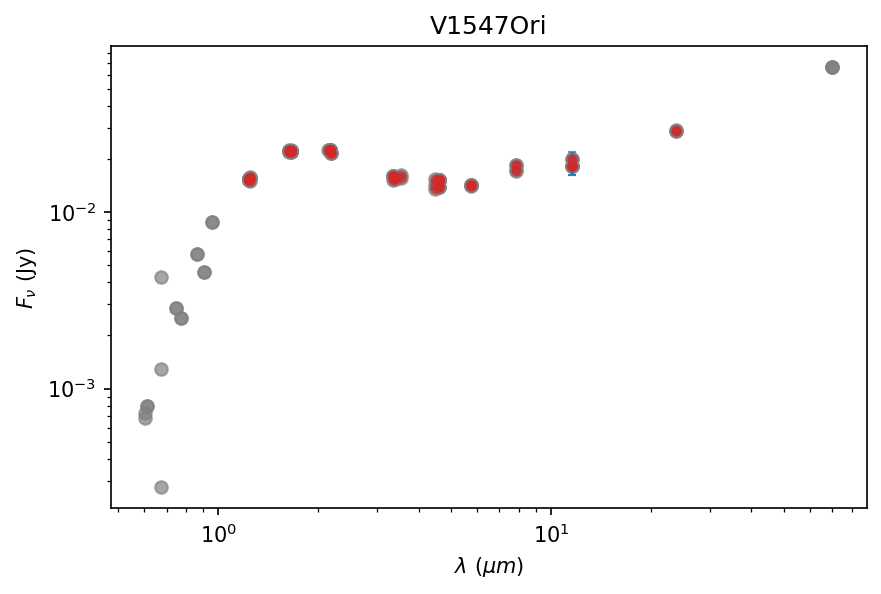

In [27]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

In [28]:
lam_, flux_, eflux_ = star.get_plot_arrays()

### By modifying the SED data

1. Merging repeated data points. VizieR-SED includes any measurement sent to CDS by authors of scientific publications and duplication of data is very common. To reduce duplications, the method `merdeRepeatedPoints` will check for SED data points which have nearly identical RA, DEC based on a tolerance `tol_arcsec` in arcseconds, and nearly identical flux, down to a tolerance `flux_tol_frac`. When repetitions are found, both are swapped by a single measurement which is the weighted average of the repetitions. Uncertainties are also propagated.

In [29]:
star.mergeRepeatedPoints(tol_arcsec=0.1, flux_tol_frac=1e-1)

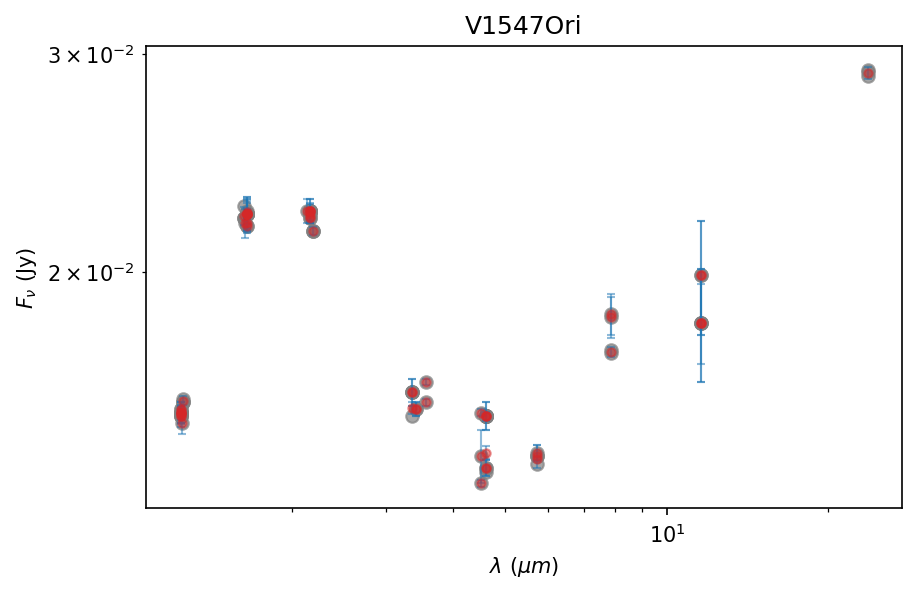

In [30]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

In [31]:
lam_, flux_, eflux_ = star.get_plot_arrays()

3. Identifying repeated sources. At any given searching radius, it is possible to have multiple detections from the same catalog. Here, we resolve these multiple detections by keeping only the closest one to the input coordinates. Multiple detections are identified based on coming from the same catalogue, having the same filters but different RA, DEC.

To illustrate the effect of this, I am repeating the query for the example soruce with a large radius. Note that this processing step alone would significantly mitigate the issue with contaminant sources, but would not fully solve it, as there may be catalogues within VizieR which only include one of them. 


In [32]:
star = Source(
    ra,
    dec,
    radius,
    ID=ID,
    raw_cache_dir=None
)
lam_, flux_, eflux_ = star.get_plot_arrays()

In [33]:
star.resolveMultipleDetections()

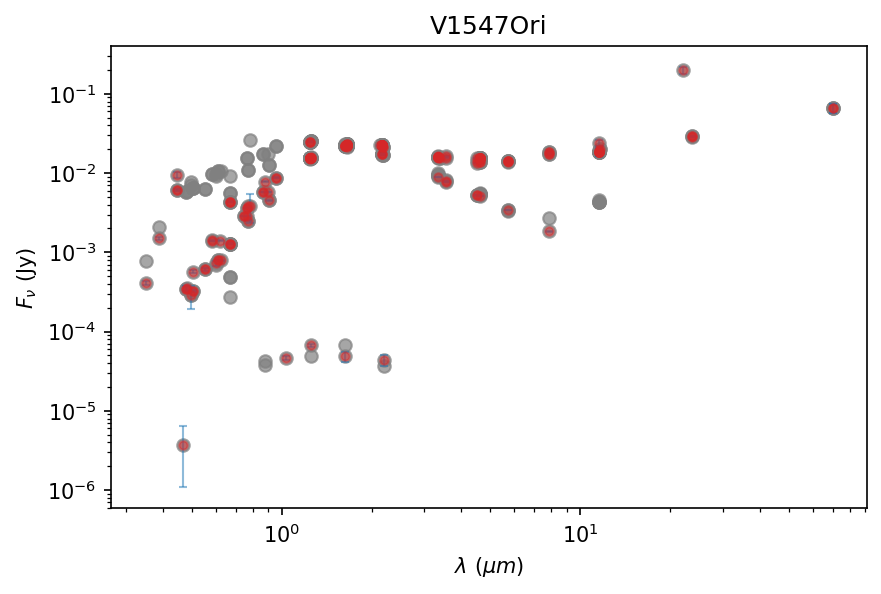

In [34]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

In [35]:
star.confine(2.)
apply_blacklist(star, blacklist_config, keys=['outdated_surveys', 'weird_surveys'])
star.mergeRepeatedPoints(tol_arcsec=0.1, flux_tol_frac=1e-1)
lam_, flux_, eflux_ = star.get_plot_arrays()

3. Merging multiple measurements. Even after all previous pre-processing steps, we may still have several datapoints for the same filters. These do include physical information, and could be showing, for example, photometric variability. However, with highly heterogeneous datasets like the ones yield by VizieR SED, they can bring biases when fitting $\alpha_{IR}$ indexes. For example, one of the most widely available data is for the $K_s$ band, whereas many telescopes share a default band very similar to the 2MASS ones. With several measurements at this band, but very few data available for far-infrared, fits to the SED can get biased by an overweight in the $K_s$ due to the larger availability of data-points. To overcome that, the `Source.aggregateFilter` method identifies multiple measurements under the same filter name, and aggregate them by weigthed-average. 

In [36]:
star.aggregateFilter()

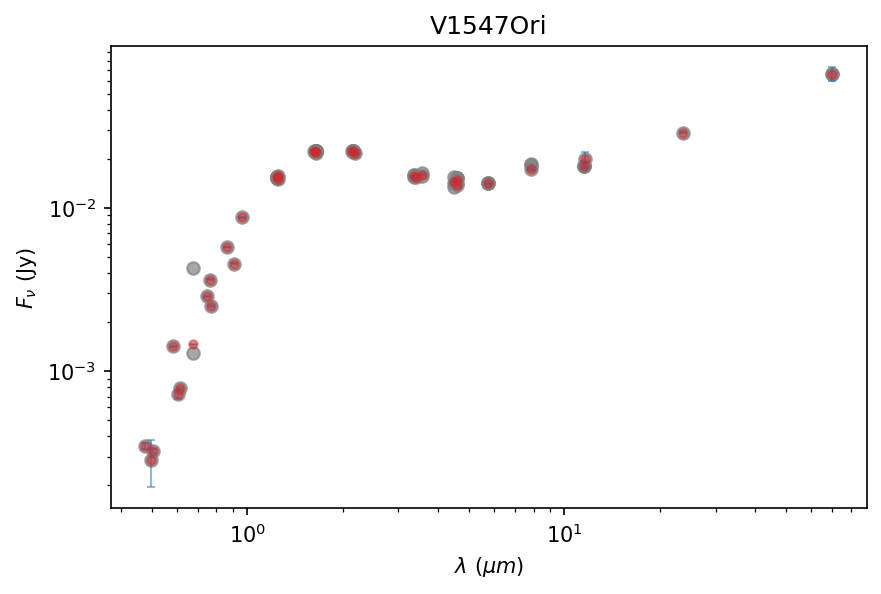

In [37]:
ax = star.plot_sed(show=False, color="tab:red", ecolor="tab:blue", alpha=0.5)
ax.plot(lam_, flux_, marker="o", ls="", color="gray", alpha=0.7, zorder=0)

## Fit an $\alpha_{IR}$ index and classify

### Standard Classification Scheme

The standard classification scheme used in `sed.YSOclassifier` is the one discussed by
[Großschedl, J. E., Alves, J., Teixeira, P. S., et al. 2019, A&A, 622, A149](https://ui.adsabs.harvard.edu/#abs/2019A%26A...628A..85V). 

It relies on fitting a linear model to a log-log version of $(\lambda F_\lambda,\lambda)$:

$$\alpha_{\mathrm{IR}}=\frac{d\log{(\lambda F_\lambda)}}{d\log{\lambda}}$$

In [38]:
from sed.classifyYSO import DEFAULT_RULES, print_rules

In [39]:
print_rules(rules=DEFAULT_RULES)

0/I             : "0/I": lambda a: np.isfinite(a) and (a > 0.3),
flat            : "flat": lambda a: np.isfinite(a) and (-0.3 < a < 0.3),
II              : "II": lambda a: np.isfinite(a) and (-1.6 < a < -0.3),
III thin disk   : "III thin disk": lambda a: np.isfinite(a) and (-2.5 < a < -1.6),
III no disk / MS: "III no disk / MS": lambda a: np.isfinite(a) and (a < -2.5),


In [40]:
from sed.classifyYSO import YSOClassifier

`sed.classifyYSO.YSOClassifier` expects an instance of `sed.vizierSED.Source`, and a lower and upper wavelengths for the SED classification. As default, it will only use data within $2-24\mu m$ unless informed otherwise. `min_points` is the minimum required number of points within the wavelength range, which are required for validating the fit. `wl_span_threshold_um` constrains the minimum distribution of datapoints in $\mu m$. For example, with it set to 2 we required that the SED includes at least 2 datapoints $2\mu m$ apart to validate a fit. This avoids fitting $\alpha_{IR}$ from data dominated by only one type of photometric band (for example, having only $K$ and $K_s$ data)


In [42]:
clf = YSOClassifier(star, 
                    lower=2.0, 
                    upper=24.0, 
                    min_points=2, 
                    wl_span_threshold_um=2.0)


`YSOClassifier` relies on `Source.sed`  having the fields `sed_lambda` in $\mu m$  and `sed_flux` and `sed_eflux` in $Jy$. It will accordingly make appropriate conversions from flux densities to flux prior fitting.  

If one wants to not use `sed.vizierSED.Source` and instead provide their own SEDs, the function
`source_from_arrays(sed_lambda, sed_flux, sed_eflux)` allows creating fake instances of `Source` from `sed_lambda, sed_flux, sed_eflux` provided in the expected units. In this case, `ID`, `ra`, and `dec` can be passed as attributes for labeling

To run the classification, the `YSOClassifier.run()` method must be used. It will return a dictionary with:

- "alpha_ir": $\alpha_{IR}$-index
- "intercept": intercept in the linear fit. 
- "wl_min": minimum wavelength of available data
- "wl_max": maximum wavelength of available data.
- "n_points": number of datapoints using for fitting.
- "class": YSO class 

In [43]:

res = clf.run()

In [44]:
res

{'alpha_ir': -0.9271841801406958,
 'intercept': -10.323490528913062,
 'wl_min': 2.1337541494661925,
 'wl_max': 23.674678828081817,
 'n_points': 14,
 'class': 'II'}

<Axes: title={'center': 'alpha=-0.93 | II | N=14'}, xlabel='$\\lambda\\ (\\mu m)$', ylabel='$\\nu F_{\\nu}\\ (erg\\ s^{-1}\\ cm^{-2})$'>

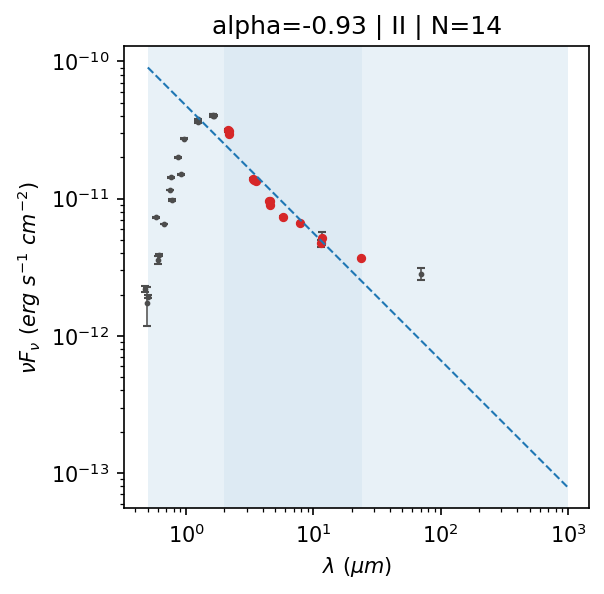

In [45]:
clf.plot(overlay_color="grey")